In [1]:
import io
import re
import string
import tqdm

import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [3]:
#https://towardsdatascience.com/optimising-your-input-pipeline-performance-with-tf-data-part-1-32e52a30cac4
#Autotune ensures, the inout data pipeline is optimized such that the system is not idle while reading inout data or training
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

In [4]:
# Generates skip-gram pairs with negative sampling for a list of sequences
# (int-encoded sentences) based on window size, number of negative samples
# and vocabulary size.
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
  # Elements of each training example are appended to these lists.
  targets, contexts, labels = [], [], []

  # Build the sampling table for `vocab_size` tokens.
  sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

  # Iterate over all sequences (sentences) in the dataset.
  for sequence in tqdm.tqdm(sequences):

    # Generate positive skip-gram pairs for a sequence (sentence).
    positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
          sequence,
          vocabulary_size=vocab_size,
          sampling_table=sampling_table,
          window_size=window_size,
          negative_samples=0)

    # Iterate over each positive skip-gram pair to produce training examples
    # with a positive context word and negative samples.
    for target_word, context_word in positive_skip_grams:
      context_class = tf.expand_dims(
          tf.constant([context_word], dtype="int64"), 1)
      negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
          true_classes=context_class,
          num_true=1,
          num_sampled=num_ns,
          unique=True,
          range_max=vocab_size,
          seed=seed,
          name="negative_sampling")

      # Build context and label vectors (for one target word)
      context = tf.concat([tf.squeeze(context_class,1), negative_sampling_candidates], 0)
      label = tf.constant([1] + [0]*num_ns, dtype="int64")

      # Append each element from the training example to global lists.
      targets.append(target_word)
      contexts.append(context)
      labels.append(label)

  return targets, contexts, labels

In [5]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

In [6]:
with open(path_to_file) as f:
  lines = f.read().splitlines()
for line in lines[:20]:
  print(line)

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.


In [7]:
text_ds = tf.data.TextLineDataset(path_to_file).filter(lambda x: tf.cast(tf.strings.length(x), bool))


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [8]:
# Now, create a custom standardization function to lowercase the text and
# remove punctuation.
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  return tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation), '')


# Define the vocabulary size and the number of words in a sequence.
vocab_size = 4096
sequence_length = 10

# Use the `TextVectorization` layer to normalize, split, and map strings to
# integers. Set the `output_sequence_length` length to pad all samples to the
# same length.
vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

In [9]:
vectorize_layer.adapt(text_ds.batch(1024))

2023-01-09 03:17:35.843805: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [10]:
# Save the created vocabulary for reference.
inverse_vocab = vectorize_layer.get_vocabulary()
print(inverse_vocab[:20])

['', '[UNK]', 'the', 'and', 'to', 'i', 'of', 'you', 'my', 'a', 'that', 'in', 'is', 'not', 'for', 'with', 'me', 'it', 'be', 'your']


In [11]:
# Vectorize the data in text_ds.
text_vector_ds = text_ds.batch(1024).prefetch(AUTOTUNE).map(vectorize_layer).unbatch()

In [12]:
sequences = list(text_vector_ds.as_numpy_iterator())
print(len(sequences))
# print(sequences)

32777


In [13]:
for seq in sequences[:5]:
  print(f"{seq} => {[inverse_vocab[i] for i in seq]}")

[ 89 270   0   0   0   0   0   0   0   0] => ['first', 'citizen', '', '', '', '', '', '', '', '']
[138  36 982 144 673 125  16 106   0   0] => ['before', 'we', 'proceed', 'any', 'further', 'hear', 'me', 'speak', '', '']
[34  0  0  0  0  0  0  0  0  0] => ['all', '', '', '', '', '', '', '', '', '']
[106 106   0   0   0   0   0   0   0   0] => ['speak', 'speak', '', '', '', '', '', '', '', '']
[ 89 270   0   0   0   0   0   0   0   0] => ['first', 'citizen', '', '', '', '', '', '', '', '']


In [14]:
targets, contexts, labels = generate_training_data(
    sequences=sequences,
    window_size=2,
    num_ns=4,
    vocab_size=vocab_size,
    seed=SEED)

targets = np.array(targets)
contexts = np.array(contexts)
labels = np.array(labels)

print('\n')
print(f"targets.shape: {targets.shape}")
print(f"contexts.shape: {contexts.shape}")
print(f"labels.shape: {labels.shape}")

100%|██████████| 32777/32777 [00:09<00:00, 3572.03it/s]




targets.shape: (64555,)
contexts.shape: (64555, 5)
labels.shape: (64555, 5)


In [15]:
BATCH_SIZE = 1024
BUFFER_SIZE = 10000
#Joins all the variables target, context and labels to make a numpy array
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
[x for x in dataset]

[((<tf.Tensor: shape=(), dtype=int64, numpy=673>,
   <tf.Tensor: shape=(5,), dtype=int64, numpy=array([125, 170,  19, 826,  57])>),
  <tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 0, 0, 0, 0])>),
 ((<tf.Tensor: shape=(), dtype=int64, numpy=125>,
   <tf.Tensor: shape=(5,), dtype=int64, numpy=array([673,   1,  20,  84,  11])>),
  <tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 0, 0, 0, 0])>),
 ((<tf.Tensor: shape=(), dtype=int64, numpy=106>,
   <tf.Tensor: shape=(5,), dtype=int64, numpy=array([  16,  280, 1633,    3,    9])>),
  <tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 0, 0, 0, 0])>),
 ((<tf.Tensor: shape=(), dtype=int64, numpy=673>,
   <tf.Tensor: shape=(5,), dtype=int64, numpy=array([  16,   43, 3718, 1032,    0])>),
  <tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 0, 0, 0, 0])>),
 ((<tf.Tensor: shape=(), dtype=int64, numpy=673>,
   <tf.Tensor: shape=(5,), dtype=int64, numpy=array([ 982,    2,    8, 2661,    1])>),
  <tf.Tensor: shape=(5,), dtype=int64, nu

In [16]:
#Batch groups the data into batch size and the remainder rows which do not divide evenly by batch size are dropped to 
# keep even number of elements in each batch
#Shuffle randomly shuffles the dataset. Buffer size should be greater than number of training examples.
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
[x for x in dataset]

[((<tf.Tensor: shape=(1024,), dtype=int64, numpy=array([2143, 1833, 2704, ...,  226, 1931, 1206])>,
   <tf.Tensor: shape=(1024, 5), dtype=int64, numpy=
   array([[  20,   53,  782,   70,   11],
          [  14,    1,   35,  311,   99],
          [  65,  208,    0,   17,  134],
          ...,
          [  48,   33,    7, 1905,  238],
          [   1,   37,    0, 2144,   61],
          [  11,    6,  348,  485,   18]])>),
  <tf.Tensor: shape=(1024, 5), dtype=int64, numpy=
  array([[1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         ...,
         [1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0]])>),
 ((<tf.Tensor: shape=(1024,), dtype=int64, numpy=array([ 898,   26,  925, ..., 3082, 1442,   49])>,
   <tf.Tensor: shape=(1024, 5), dtype=int64, numpy=
   array([[ 213,  965,  118,  108,  116],
          [ 129,  798,  173, 2535,   89],
          [ 302,    1,   17, 1699,   20],
          ...,
          [ 172,   11,  172,  101,  473],
          [   2, 

In [17]:
#Cache the dataset
#  number of elements that will be buffered when prefetching
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
[x for x in dataset]

[((<tf.Tensor: shape=(1024,), dtype=int64, numpy=array([ 700,  477, 1797, ...,  664, 2881, 3601])>,
   <tf.Tensor: shape=(1024, 5), dtype=int64, numpy=
   array([[ 296,    9,    4,   49,    1],
          [2663, 1857,  527,    0,  245],
          [   8,  824, 2563,    2,   42],
          ...,
          [   5, 3878, 2241,  175, 3194],
          [  12,  180,  831,   73,   12],
          [ 115,   22, 2833,   21, 1463]])>),
  <tf.Tensor: shape=(1024, 5), dtype=int64, numpy=
  array([[1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         ...,
         [1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0]])>),
 ((<tf.Tensor: shape=(1024,), dtype=int64, numpy=array([  29, 1390, 1424, ...,  747,  437, 1572])>,
   <tf.Tensor: shape=(1024, 5), dtype=int64, numpy=
   array([[  31,    5,    0,  372,   37],
          [   6,  669,  468,   24, 2092],
          [  11,  689,  255,  162,   64],
          ...,
          [ 694,    9,    1,  341,    0],
          [ 580, 

In [18]:
num_ns = 4
class Word2Vec(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim):
    super(Word2Vec, self).__init__()
    self.target_embedding = layers.Embedding(vocab_size,
                                      embedding_dim,
                                      input_length=1,
                                      name="w2v_embedding")
    self.context_embedding = layers.Embedding(vocab_size,
                                       embedding_dim,
                                       input_length=num_ns+1)

  def call(self, pair):
    target, context = pair
    # target: (batch, dummy?)  # The dummy axis doesn't exist in TF2.7+
    # context: (batch, context)
    if len(target.shape) == 2:
      target = tf.squeeze(target, axis=1)
    # target: (batch,)
    word_emb = self.target_embedding(target)
    # word_emb: (batch, embed)
    context_emb = self.context_embedding(context)
    # context_emb: (batch, context, embed)
    dots = tf.einsum('be,bce->bc', word_emb, context_emb)
    # dots: (batch, context)
    return dots

In [19]:
def custom_loss(x_logit, y_true):
      return tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=y_true)

In [20]:
embedding_dim = 128
word2vec = Word2Vec(vocab_size, embedding_dim)
word2vec.compile(optimizer='adam',
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

In [21]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [22]:
word2vec.fit(dataset, epochs=20, callbacks=[tensorboard_callback])

Epoch 1/20
63/63 [==============================] - 1s 5ms/step - loss: 1.6082 - accuracy: 0.2342
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 1.5890 - accuracy: 0.5535
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 1.5410 - accuracy: 0.6042
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 1.4574 - accuracy: 0.5748
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 1.3586 - accuracy: 0.5801
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 1.2617 - accuracy: 0.6074
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 1.1713 - accuracy: 0.6414
Epoch 8/20
63/63 [==============================] - 1s 13ms/step - loss: 1.0875 - accuracy: 0.6766
Epoch 9/20
63/63 [==============================] - 1s 14ms/step - loss: 1.0097 - accuracy: 0.7092
Epoch 10/20
63/63 [==============================] - 1s 10ms/step - loss: 0.9376 - accuracy: 0.7377
Epoch 11/20
63/6

In [23]:
#docs_infra: no_execute
%tensorboard --logdir logs

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

In [24]:
weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

In [25]:
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [50]:
import pandas as pd
weightDF = pd.DataFrame(weights.numpy())

In [56]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
weightDFPCA = pca.fit_transform(weightDF.to_numpy())
print('Variance explained by each component - ', pca.explained_variance_ratio_)
print('Variance explained by 2 components ', round((sum(pca.explained_variance_ratio_)*100),2), '%' )
print('Co-effecient of original component to the PCA axis - ', pca.components_)

Variance explained by each component -  [0.06164435 0.04160167]
Variance explained by 2 components  10.32 %
Co-effecient of original component to the PCA axis -  [[-1.33694798e-01  2.01796237e-02  1.42366793e-02 -1.91006623e-02
  -1.08617783e-01  4.54125516e-02 -7.14806169e-02  2.60851402e-02
   6.01915792e-02  1.05904356e-01 -6.70366511e-02 -4.04452682e-02
   1.30111575e-01  6.91072643e-02 -6.68610483e-02 -8.82954746e-02
   7.43447766e-02 -3.72768566e-02 -1.09778032e-01  3.75242606e-02
   7.96136539e-03  4.78212424e-02 -2.52792127e-02 -1.34586379e-01
  -4.60686609e-02  9.40015540e-02 -7.58761019e-02 -2.06347220e-02
  -3.59683367e-03  1.10963419e-01 -1.91700310e-02  2.57962048e-02
   1.26479432e-01  1.04492456e-02  5.49857803e-02  1.13328189e-01
  -9.80926007e-02  3.24041843e-02 -1.10035567e-02 -2.63938289e-02
   4.45770472e-02  4.73589860e-02 -1.68429911e-01 -5.86816669e-02
   2.36540679e-02 -2.18829922e-02 -5.77088445e-02 -1.67420745e-01
   9.40311551e-02 -8.83750468e-02 -9.44252610e

In [63]:
len(vocab[1:])
# len(weightDFPCA)

4095

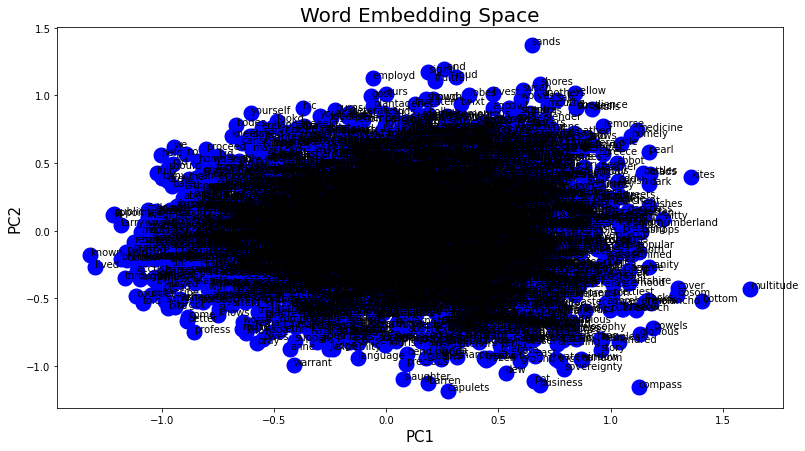

In [64]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13,7))
plt.scatter(weightDFPCA[:,0],weightDFPCA[:,1],linewidths=10,color='blue')
plt.xlabel("PC1",size=15)
plt.ylabel("PC2",size=15)
plt.title("Word Embedding Space",size=20)
for i, word in enumerate(vocab[1:]):
  plt.annotate(word,xy=(weightDFPCA[i,0],weightDFPCA[i,1]))